# Overview
This notebook extends the initial use case by incorporating advanced experiments and feature engineering techniques that were not explored previously. The use of  tools like MLflow, Optuna, and FastAPI has significantly improved the model's development and deployment processes.


### Dimensionality Reduction on Categorical Feature
Country was  excluded in the previous attempt due to high cardinality. This issue was resolved by using PCA to reduce the dimensionality of its one-hot encoded form. Although fifty principal components were optimal for capturing variance, only three were used. This decision was made to balance the dimensionality reduction goal with the need to avoid overly simplifying the data, which could potentially lose meaningful variance.

### Feature Engineering
Two new features were introduced to better capture user behavior and interactions between the original features:
- **User Engagement Depth**: Calculated as the ratio of `totalPageviews` to `totalVisits`, this feature provides insights into how deeply users are engaging with the content.
- **Cluster Assignment**: Each instance was assigned to a cluster based on features like `TotalPageviews`, `TotalVisits`, `UserEngagementDepth`, and the number of visits from Desktop, Mobile, and Tablet. Clustering was performed using the K-means algorithm, with the optimal number of clusters determined to be six using the elbow method.

## Dataset Sampling
A different approach was taken for sampling the holdout set in this iteration:
- **Training Data**: Includes instances from the first eight months.
- **Testing Data**: Comprises instances from the last four months.
- **Validation Splitting**: The training data was further split into training and validation sets using stratified sampling to ensure that both sets are representative of the overall dataset.

## Modeling Approach

### Model Training and Logging
The modeling approach was similar to previous efforts but included enhancements such as integration with MLflow for detailed logging of experiments:
- **Hyperparameter Tuning**: Optuna was utilized to fine-tune the model parameters to optimize performance.
- **Model Interpretability**: SHAP (SHapley Additive exPlanations) was employed to provide both local and summary explanations of the model, enhancing transparency and understanding of model decisions.

### Best Model Strategy
- **Data Balancing**: The best model was trained on an undersampled training dataset where the majority class was randomly reduced to match the minority class, primarily for efficiency reasons.
- **Model Deployment**: The trained model was served through an API endpoint obtained from MLflow. Additionally, a FastAPI was developed for the user interface, enhancing the accessibility and usability of the model predictions.
- **Containerization**: Both the model and the FastAPI application were dockerized to ensure easy deployment and scalability.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,f1_score, recall_score, precision_score,fbeta_score,make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import RFE

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from collections import Counter
from scipy.stats import uniform


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassPredictionError


In [2]:
df=pd.read_csv(r"D:\Google Drive\McGill\Winter Semester\W2\Enterprise 2\Group Project\Revenue-Radar\train_df.csv")
pd.set_option('display.max_columns', None)
df.head(1)


,fullVisitorId,FirstChannelVisit,LastChannelVisit,at_least_one_conversion,country,continent,subContinent,TotalVisits,TotalBounces,Organic Search,Social,Direct,Paid Search,Referral,Affiliates,Display,(Other),TotalPageviews,desktop,mobile,tablet,FirstSessionPageviews,LastSessionPageviews,CampaignVisits,isTrueDirect,AdContentVisits,Source_PC1,Source_PC2,Source_PC3
0,4823595352351,Organic Search,Organic Search,0,China,Asia,Eastern Asia,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,-0.406531,-0.073766,0.171027


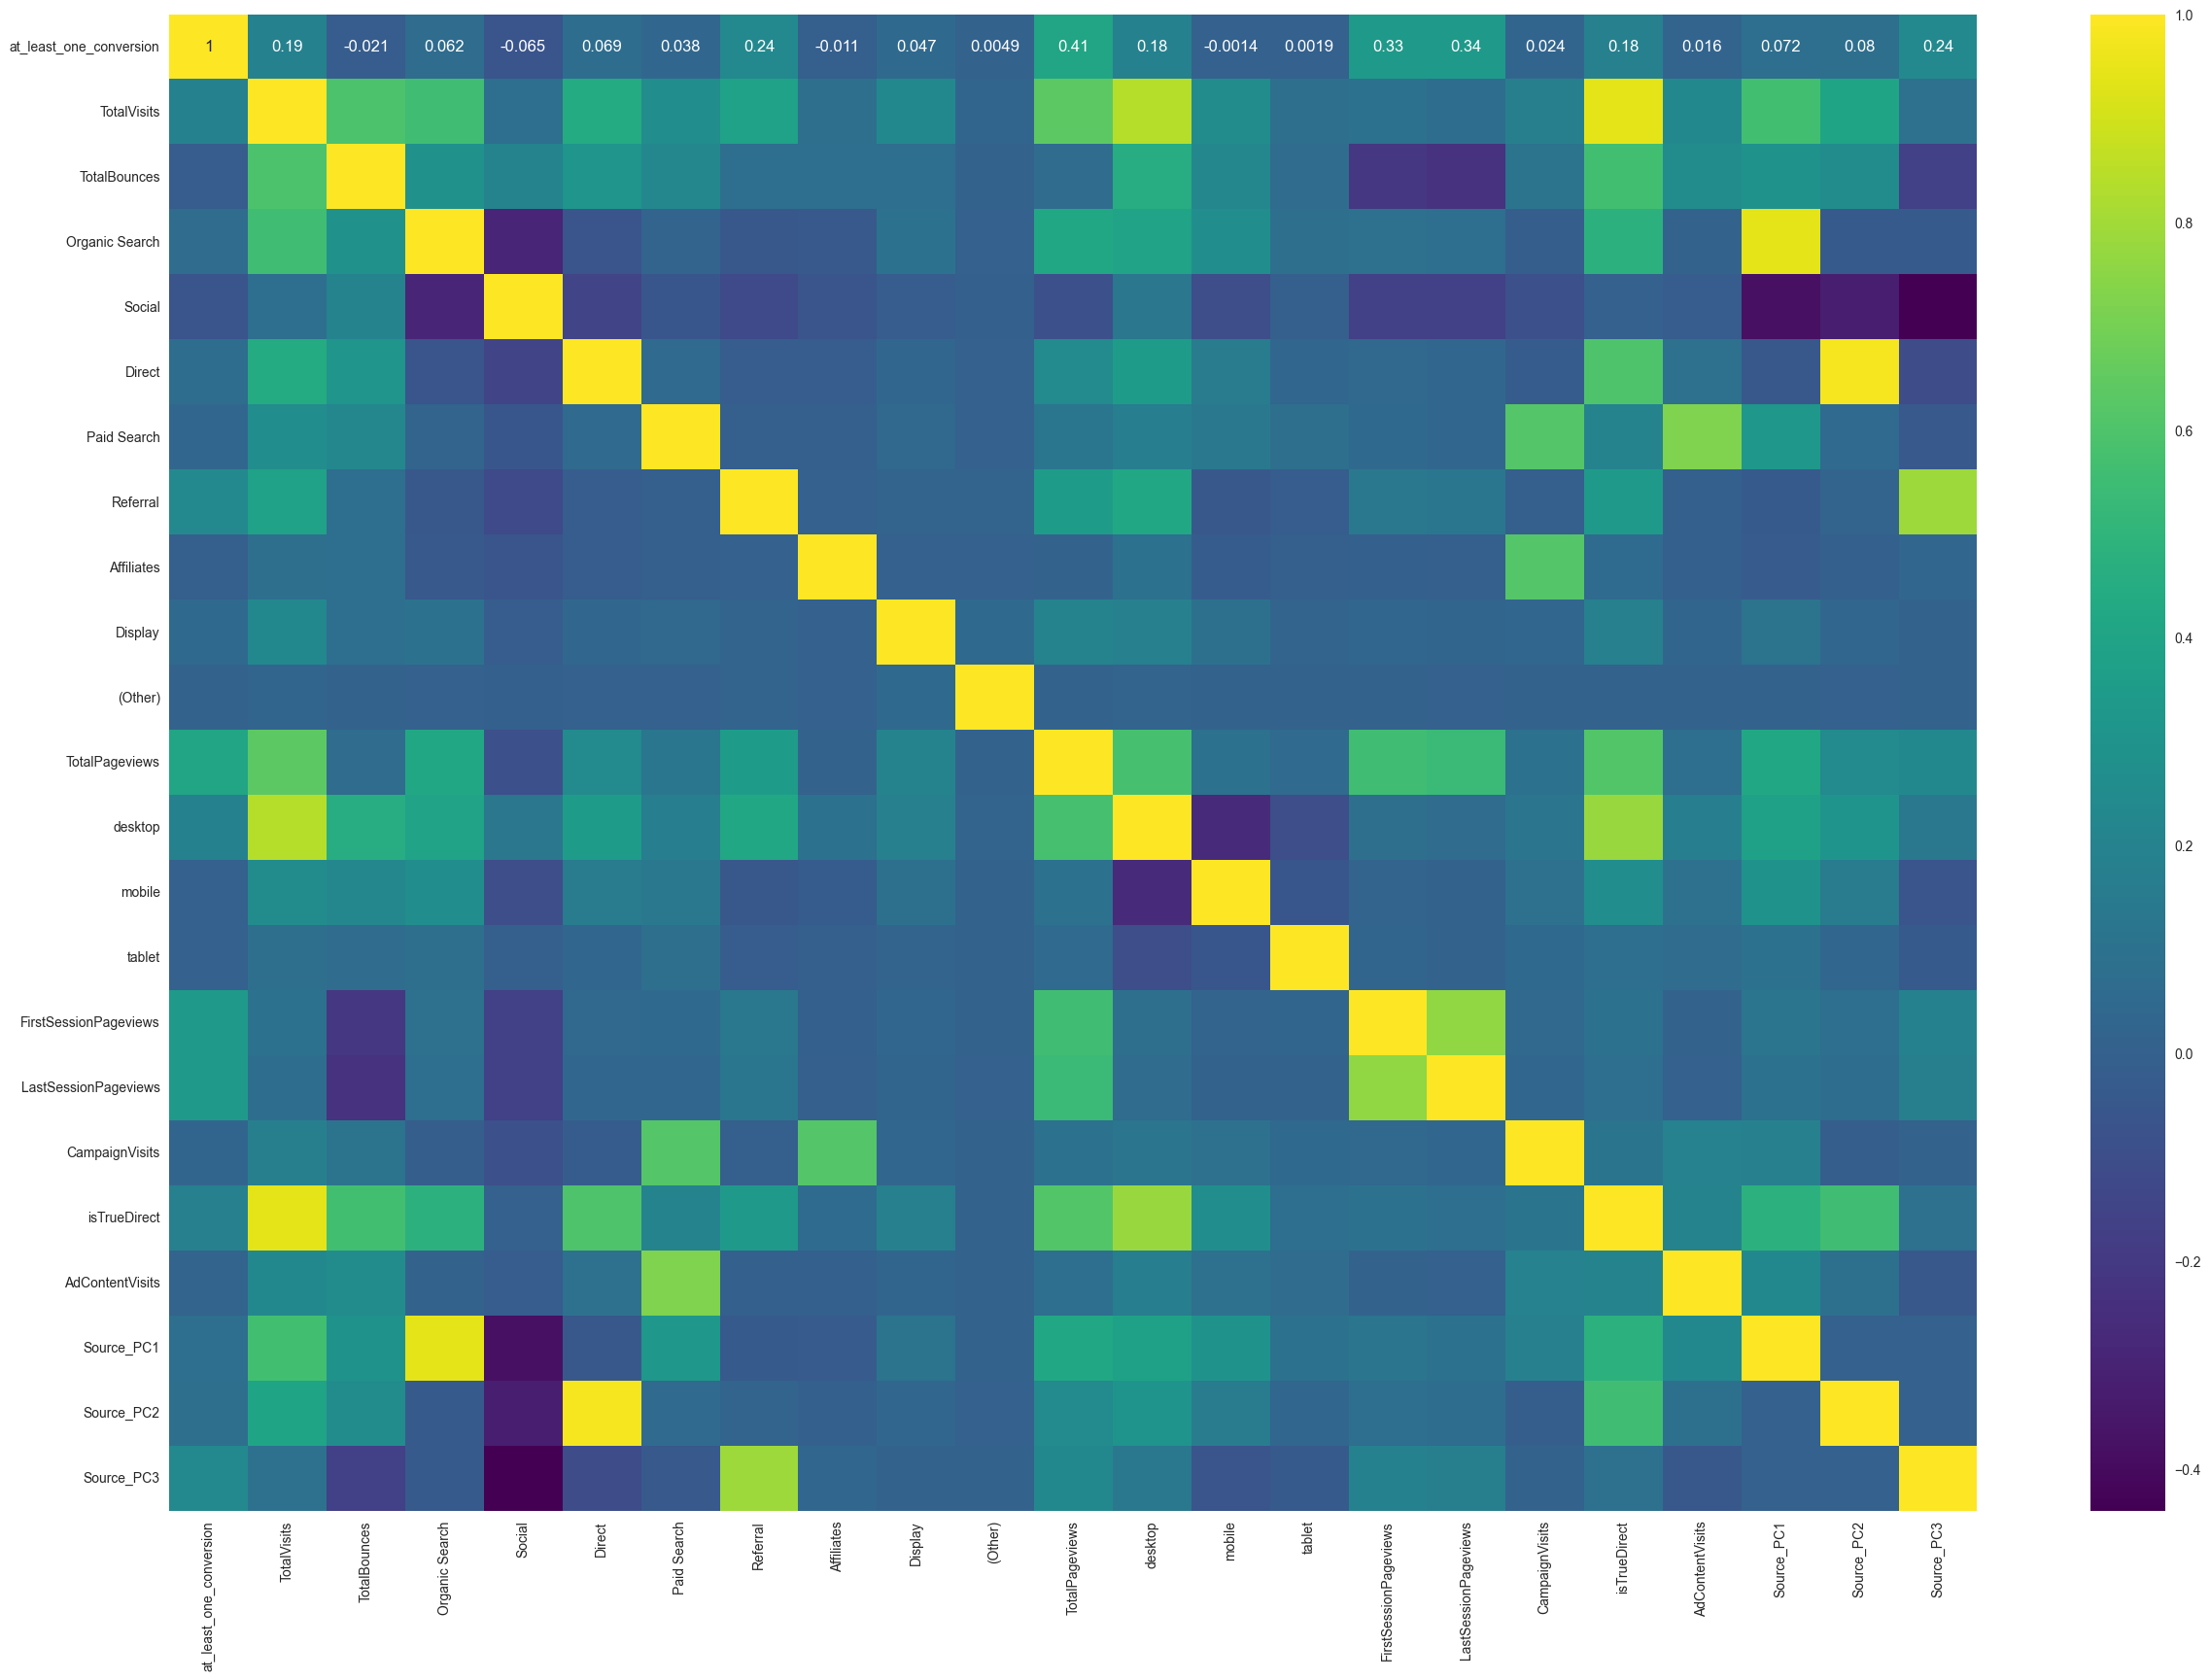

In [3]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(30,20))
sns.heatmap(numeric_df.corr(),annot=True,cmap='viridis');

In [4]:
#numeric_df.corr()

# correlation gretaer than 0.5
correlation = numeric_df.corr()
correlation = correlation.abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation = correlation[correlation > 0.5]
correlation = correlation[correlation < 1]
correlation = pd.DataFrame(correlation).reset_index()
correlation.columns = ['feature1', 'feature2', 'correlation']




In [5]:
def preprocess_data(df, country_categories, pca_model=None, kmeans_model=None, fit_pca=True, fit_kmeans=True):
    # Validate presence of 'fullVisitorId'
    if 'fullVisitorId' not in df.columns:
        raise KeyError("DataFrame must include 'fullVisitorId' column.")

    # Calculate User Engagement Depth
    df['UserEngagementDepth'] = df['TotalPageviews'] / df['TotalVisits']
    df['UserEngagementDepth'].replace([float('inf'), -float('inf'), float('nan')], 0, inplace=True)
    
    # Standardize select features for clustering to improve performance
    features_for_clustering = ['TotalPageviews', 'TotalVisits', 'UserEngagementDepth', 'desktop', 'mobile', 'tablet']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features_for_clustering])
    
    # Perform clustering
    if fit_kmeans:
        kmeans_model = KMeans(n_clusters=6, random_state=42)
        clusters = kmeans_model.fit_predict(scaled_features)
    else:
        clusters = kmeans_model.predict(scaled_features)
    df['ClusterLabel'] = clusters
    # One-hot encode the cluster labels if necessary
    cluster_dummies = pd.get_dummies(df['ClusterLabel'], prefix='Cluster', dtype='int64',drop_first=True)
    df = pd.concat([df, cluster_dummies], axis=1)
    df.drop('ClusterLabel', axis=1, inplace=True)

    
    # One-hot encode 'country' and reindex with all possible categories to ensure consistency
    country_encoded = pd.get_dummies(df['country'], prefix='country')
    country_encoded = country_encoded.reindex(columns=['country_' + c for c in country_categories], fill_value=0)
    
    if fit_pca:
        pca_model = PCA(n_components=3)
        country_pca = pca_model.fit_transform(country_encoded)
    else:
        country_pca = pca_model.transform(country_encoded)
    
    country_pca_df = pd.DataFrame(country_pca, columns=['country_PC1', 'country_PC2', 'country_PC3'])
    
    # Merge PCA data back, ensure 'fullVisitorId' is available for any needed operations
    country_pca_df['fullVisitorId'] = df['fullVisitorId'].values
    df = pd.merge(df, country_pca_df, on='fullVisitorId', how='inner')

    df.drop(['fullVisitorId', 'country', 'TotalVisits', 'LastSessionPageviews', 'TotalPageviews'], axis=1, inplace=True)
    
    # Handle other categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='int64')
    
    X = df.drop('at_least_one_conversion', axis=1)
    y = df['at_least_one_conversion']
    
    return X, y, pca_model, kmeans_model

### Splitting the dataset into train, test, and validation sets
- Chose stratified sampling to maintain class distribution

In [6]:
# Split the data into training and validation sets directly
df_train, df_val = train_test_split(df, test_size=0.15, random_state=42, stratify=df['at_least_one_conversion'])


In [7]:
country_categories = df['country'].unique().tolist()

In [8]:
# Preprocess the training data; assuming preprocess_data is modified to fit models
X_train, y_train, pca_train, kmeans_train = preprocess_data(df_train, country_categories, fit_pca=True, fit_kmeans=True)


In [9]:
# Preprocess the validation data using the existing PCA and KMeans models
X_val, y_val, _, _ = preprocess_data(df_val, country_categories, pca_model=pca_train, kmeans_model=kmeans_train, fit_pca=False, fit_kmeans=False)


In [10]:
test_df=pd.read_csv(r"D:\Google Drive\McGill\Winter Semester\W2\Enterprise 2\Group Project\Revenue-Radar\test_df.csv")

X_test, y_test, _, _ = preprocess_data(test_df, country_categories, pca_model=pca_train, kmeans_model=kmeans_train, fit_pca=False, fit_kmeans=False)

In [11]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [13]:
from matplotlib.colors import ListedColormap
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")

    else:
        predictions_val = clf.predict(X_val)
        probas_val = clf.predict_proba(X_val)[:, 1]  
        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val).im_.set_cmap(ListedColormap(['#34a853', '#4285f4', '#fbbb07']))
        plt.show()
        print("End of validation Result\n")


In [14]:
X_train.head(1)

,TotalBounces,Organic Search,Social,Direct,Paid Search,Referral,Affiliates,Display,(Other),desktop,mobile,tablet,FirstSessionPageviews,CampaignVisits,isTrueDirect,AdContentVisits,Source_PC1,Source_PC2,Source_PC3,UserEngagementDepth,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,country_PC1,country_PC2,country_PC3,FirstChannelVisit_Affiliates,FirstChannelVisit_Direct,FirstChannelVisit_Display,FirstChannelVisit_Organic Search,FirstChannelVisit_Paid Search,FirstChannelVisit_Referral,FirstChannelVisit_Social,LastChannelVisit_Affiliates,LastChannelVisit_Direct,LastChannelVisit_Display,LastChannelVisit_Organic Search,LastChannelVisit_Paid Search,LastChannelVisit_Referral,LastChannelVisit_Social,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,subContinent_Australasia,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe
0,3,1,0,0,0,4,0,0,0,5,0,0,1,0,3,0,0.571782,-0.093988,0.093681,5.0,0,0,0,0,0,-0.414732,0.909211,0.014557,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Feature Selection Using Random Forest

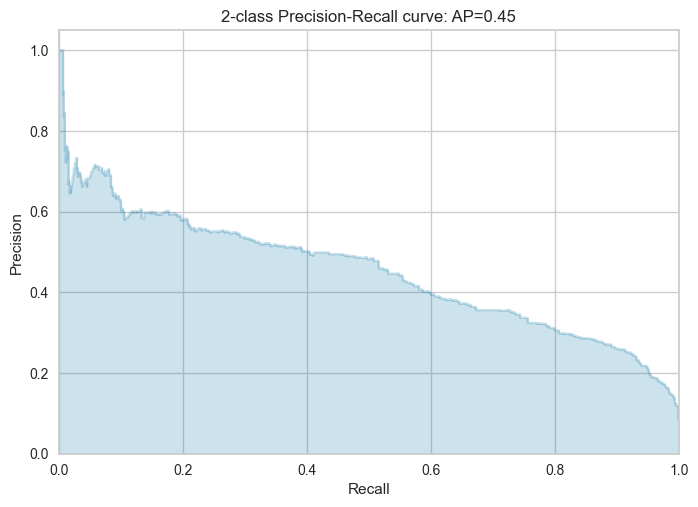

roc auc score: 0.9860636681070257



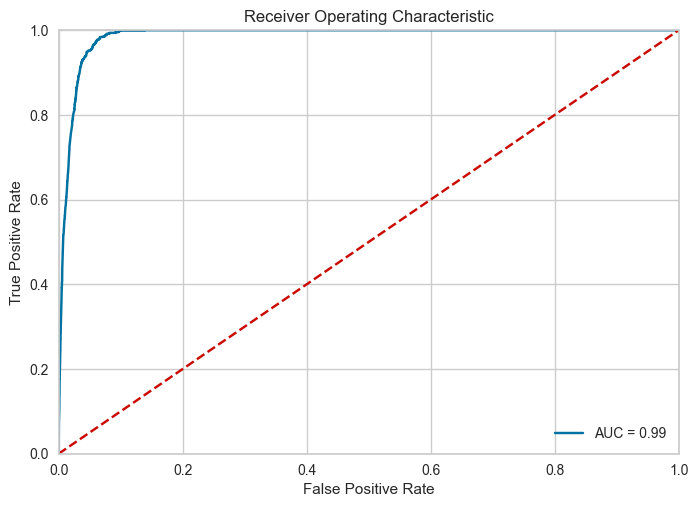

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     84092
           1       0.15      0.98      0.27      1114

    accuracy                           0.93     85206
   macro avg       0.58      0.96      0.62     85206
weighted avg       0.99      0.93      0.95     85206


Confusion Matrix: 
 [[78104  5988]
 [   17  1097]]



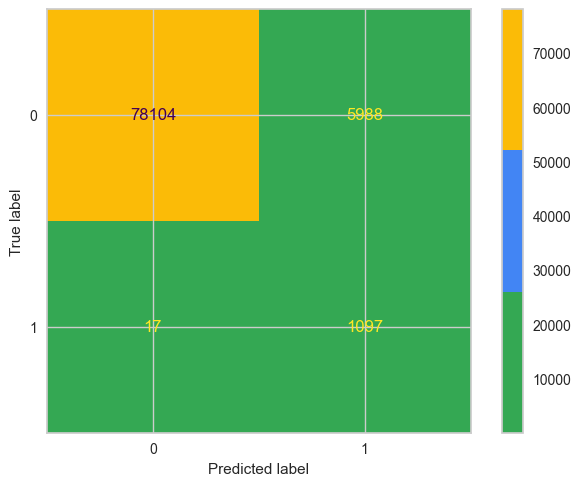

End of validation Result



In [15]:
rf_model=RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
clf_score(rf_model, X_train, y_train, X_val, y_val, train=False)

In [16]:
# getting the feature importance from the random forest model   
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)


Text(0.5, 1.0, 'Feature Importance')

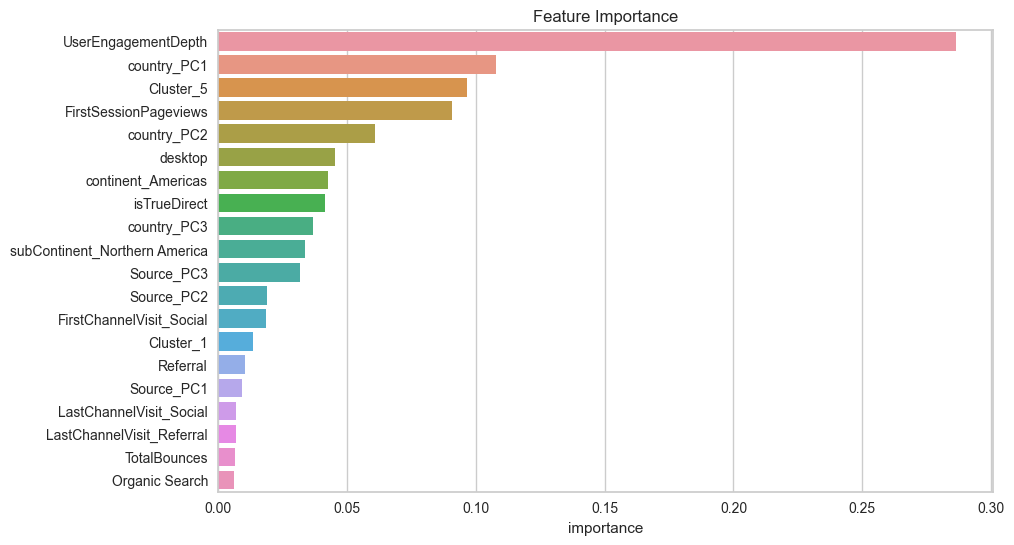

In [17]:
#plotting the top 20 features
plt.figure(figsize=(10, 6)) 
sns.barplot(x=feature_importances['importance'][:20], y=feature_importances.index[:20]);
plt.title('Feature Importance')


In [18]:
# Using the top 20 features from the random forest model
top_features = feature_importances.index[:20]
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]


In [21]:
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import optuna

# Set the experiment name in MLflow
mlflow.set_experiment('classification')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def focal_loss_objective(predt: np.ndarray, dtrain: xgb.DMatrix):
    gamma = 2.0
    alpha = 0.25
    labels = dtrain.get_label()
    preds = sigmoid(predt)
    grad = preds - labels
    hess = preds * (1 - preds)
    return alpha * grad, alpha * hess

def objective(trial):
    # Hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    }

    # Create DMatrix for training and validation
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # XGBoost training
    model = xgb.train(params, dtrain, num_boost_round=2000,
                      evals=[(dval, 'eval')], early_stopping_rounds=50,
                      obj=focal_loss_objective, verbose_eval=100)
    
    # Evaluation
    preds = model.predict(dval)
    pred_labels = (preds > 0.5).astype(int)
    f1 = f1_score(y_val, pred_labels)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)

# MLflow logging
with mlflow.start_run():
    mlflow.log_params(best_params)
    mlflow.xgboost.log_model(best_model, "model")
    evaluate_and_log_metrics(best_model, 0.5)

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for name, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        preds = (probs >= threshold).astype(int)
        mlflow.log_metrics({
            f'{name}_accuracy': accuracy_score(y, preds),
            f'{name}_precision': precision_score(y, preds),
            f'{name}_recall': recall_score(y, preds),
            f'{name}_f1': f1_score(y, preds),
            f'{name}_roc_auc': roc_auc_score(y, probs)
        })


# Create an Optuna study and find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = xgb.XGBClassifier(**{k: v for k, v in best_trial.params.items()}, objective=focal_loss_objective, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial)


[I 2024-04-25 18:56:38,326] A new study created in memory with name: no-name-c8ff0467-c40e-4b84-b0aa-a590e195a6ae


[0]	eval-rmse:0.26771
[51]	eval-rmse:5.05588


[I 2024-04-25 18:56:43,126] Trial 0 finished with value: 0.25667655786350146 and parameters: {'n_estimators': 732, 'max_depth': 8, 'learning_rate': 0.09218728564827008, 'subsample': 0.8058317490336502, 'colsample_bytree': 0.6871627510682472, 'min_child_weight': 16, 'gamma': 0.13180465515453754, 'reg_lambda': 0.6798415994426771, 'reg_alpha': 2.6090830216347832e-08}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.17689
[50]	eval-rmse:6.24083


[I 2024-04-25 18:56:48,011] Trial 1 finished with value: 0.22375478927203069 and parameters: {'n_estimators': 1534, 'max_depth': 10, 'learning_rate': 0.13194631001733167, 'subsample': 0.836222858163905, 'colsample_bytree': 0.5638966009459339, 'min_child_weight': 206, 'gamma': 0.17453802807075133, 'reg_lambda': 1.9464060434533106e-06, 'reg_alpha': 0.0022122773324625236}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.45319
[60]	eval-rmse:1.34975


[I 2024-04-25 18:56:53,237] Trial 2 finished with value: 0.11267605633802816 and parameters: {'n_estimators': 575, 'max_depth': 9, 'learning_rate': 0.018366969296921803, 'subsample': 0.9062332028228766, 'colsample_bytree': 0.6181273206938956, 'min_child_weight': 11, 'gamma': 0.22615374504545718, 'reg_lambda': 6.90322461997593, 'reg_alpha': 0.8053713183323136}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.35401
[52]	eval-rmse:3.41463


[I 2024-04-25 18:56:57,747] Trial 3 finished with value: 0.12695795548227534 and parameters: {'n_estimators': 716, 'max_depth': 5, 'learning_rate': 0.0576544969246923, 'subsample': 0.9467474067163, 'colsample_bytree': 0.8421256162545911, 'min_child_weight': 124, 'gamma': 0.23763487314010076, 'reg_lambda': 1.3214638138270216e-08, 'reg_alpha': 0.053679762032802426}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.28789
[50]	eval-rmse:4.56116


[I 2024-04-25 18:57:01,994] Trial 4 finished with value: 0.045256744995648385 and parameters: {'n_estimators': 1307, 'max_depth': 5, 'learning_rate': 0.08448514363994543, 'subsample': 0.9864808497831119, 'colsample_bytree': 0.8176449234190987, 'min_child_weight': 297, 'gamma': 0.8406812541527983, 'reg_lambda': 0.00037978073420592417, 'reg_alpha': 5.837079350649488e-07}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.44323
[59]	eval-rmse:1.60747


[I 2024-04-25 18:57:07,019] Trial 5 finished with value: 0.08828522920203734 and parameters: {'n_estimators': 1249, 'max_depth': 5, 'learning_rate': 0.02223680777242372, 'subsample': 0.9320419065277192, 'colsample_bytree': 0.5175719678692507, 'min_child_weight': 43, 'gamma': 0.536508757130544, 'reg_lambda': 0.0018375524873403635, 'reg_alpha': 8.352338191173034e-05}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.41190
[54]	eval-rmse:2.23934


[I 2024-04-25 18:57:12,127] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 1030, 'max_depth': 3, 'learning_rate': 0.03471064891891183, 'subsample': 0.5188478295513113, 'colsample_bytree': 0.7224532662377794, 'min_child_weight': 146, 'gamma': 0.43201246807514615, 'reg_lambda': 0.00010950013837306215, 'reg_alpha': 4.510076152515132e-08}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.32202
[52]	eval-rmse:4.07090


[I 2024-04-25 18:57:17,147] Trial 7 finished with value: 0.19812792511700467 and parameters: {'n_estimators': 591, 'max_depth': 10, 'learning_rate': 0.0704189970283991, 'subsample': 0.99312760500861, 'colsample_bytree': 0.8262310995809402, 'min_child_weight': 89, 'gamma': 0.12264494922992104, 'reg_lambda': 0.005894027212012004, 'reg_alpha': 7.838693346182691e-07}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.43239
[57]	eval-rmse:1.84526


[I 2024-04-25 18:57:21,933] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1775, 'max_depth': 4, 'learning_rate': 0.026655041410038202, 'subsample': 0.7640924457169158, 'colsample_bytree': 0.7457932850837204, 'min_child_weight': 291, 'gamma': 0.7100985278199018, 'reg_lambda': 1.790369732722342e-07, 'reg_alpha': 9.175436739064203e-07}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.39121
[54]	eval-rmse:2.71637


[I 2024-04-25 18:57:26,450] Trial 9 finished with value: 0.17183770883054889 and parameters: {'n_estimators': 1781, 'max_depth': 6, 'learning_rate': 0.04274459585793689, 'subsample': 0.8702880132807205, 'colsample_bytree': 0.8180384777479384, 'min_child_weight': 53, 'gamma': 0.1328189812478366, 'reg_lambda': 0.00010675034845552273, 'reg_alpha': 2.8139522492192087e-06}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.10045
[49]	eval-rmse:6.47103


[I 2024-04-25 18:57:30,687] Trial 10 finished with value: 0.22323462414578588 and parameters: {'n_estimators': 940, 'max_depth': 8, 'learning_rate': 0.18896823550877684, 'subsample': 0.6295906985502507, 'colsample_bytree': 0.9525958983243845, 'min_child_weight': 219, 'gamma': 0.33319592231164363, 'reg_lambda': 7.290700842187869, 'reg_alpha': 1.5155295522117555e-08}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.17561
[50]	eval-rmse:6.22430


[I 2024-04-25 18:57:35,077] Trial 11 finished with value: 0.21604938271604937 and parameters: {'n_estimators': 1463, 'max_depth': 8, 'learning_rate': 0.13254065519760583, 'subsample': 0.7860246950188694, 'colsample_bytree': 0.6180501779551459, 'min_child_weight': 208, 'gamma': 0.1709631746883717, 'reg_lambda': 1.7225153345477488e-06, 'reg_alpha': 0.0011199987632622556}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.21589
[50]	eval-rmse:5.77733


[I 2024-04-25 18:57:39,706] Trial 12 finished with value: 0.21533694810224632 and parameters: {'n_estimators': 1551, 'max_depth': 10, 'learning_rate': 0.11459070965657182, 'subsample': 0.8209242244306086, 'colsample_bytree': 0.5020824018905035, 'min_child_weight': 201, 'gamma': 0.10272323963008657, 'reg_lambda': 0.49734603795789706, 'reg_alpha': 0.0014286062711440064}. Best is trial 0 with value: 0.25667655786350146.


[0]	eval-rmse:0.10090
[49]	eval-rmse:6.77226


[I 2024-04-25 18:57:44,038] Trial 13 finished with value: 0.2820143884892086 and parameters: {'n_estimators': 974, 'max_depth': 8, 'learning_rate': 0.18052011321561512, 'subsample': 0.6671561397059154, 'colsample_bytree': 0.6239254176573935, 'min_child_weight': 168, 'gamma': 0.17191393209762848, 'reg_lambda': 4.754766746429928e-07, 'reg_alpha': 7.81985129770089e-05}. Best is trial 13 with value: 0.2820143884892086.


[0]	eval-rmse:0.11633
[49]	eval-rmse:7.01899


[I 2024-04-25 18:57:48,498] Trial 14 finished with value: 0.28267045454545453 and parameters: {'n_estimators': 871, 'max_depth': 7, 'learning_rate': 0.1640875061730041, 'subsample': 0.6754881668814994, 'colsample_bytree': 0.6763240145569391, 'min_child_weight': 106, 'gamma': 0.18510722923182388, 'reg_lambda': 0.029148022401859208, 'reg_alpha': 2.587214311990358e-05}. Best is trial 14 with value: 0.28267045454545453.


[0]	eval-rmse:0.09725
[50]	eval-rmse:7.47534


[I 2024-04-25 18:57:53,214] Trial 15 finished with value: 0.29014084507042254 and parameters: {'n_estimators': 1018, 'max_depth': 7, 'learning_rate': 0.1875596778519326, 'subsample': 0.6766442446758252, 'colsample_bytree': 0.6657672447711751, 'min_child_weight': 85, 'gamma': 0.25818787197900933, 'reg_lambda': 0.029948371284825047, 'reg_alpha': 4.271186578430042e-05}. Best is trial 15 with value: 0.29014084507042254.


[0]	eval-rmse:0.47389
[69]	eval-rmse:0.82318


[I 2024-04-25 18:57:59,212] Trial 16 finished with value: 0.0 and parameters: {'n_estimators': 1152, 'max_depth': 7, 'learning_rate': 0.010233089961578824, 'subsample': 0.6832584301878255, 'colsample_bytree': 0.6805422046186109, 'min_child_weight': 97, 'gamma': 0.29298627591557014, 'reg_lambda': 0.03499145143247692, 'reg_alpha': 1.6255804894587205e-05}. Best is trial 15 with value: 0.29014084507042254.


[0]	eval-rmse:0.10105
[49]	eval-rmse:7.38773


[I 2024-04-25 18:58:03,749] Trial 17 finished with value: 0.2867281760113556 and parameters: {'n_estimators': 817, 'max_depth': 7, 'learning_rate': 0.1980777712817454, 'subsample': 0.5678212376109439, 'colsample_bytree': 0.9178766089267507, 'min_child_weight': 80, 'gamma': 0.360661281760312, 'reg_lambda': 0.07404988415991184, 'reg_alpha': 0.052283999171944984}. Best is trial 15 with value: 0.29014084507042254.


[0]	eval-rmse:0.23703
[50]	eval-rmse:5.49084


[I 2024-04-25 18:58:08,467] Trial 18 finished with value: 0.26150474799123447 and parameters: {'n_estimators': 810, 'max_depth': 6, 'learning_rate': 0.1055611999911113, 'subsample': 0.5405946916824789, 'colsample_bytree': 0.993212448278311, 'min_child_weight': 73, 'gamma': 0.4000139877942702, 'reg_lambda': 0.23179096133640611, 'reg_alpha': 7.875651427483223}. Best is trial 15 with value: 0.29014084507042254.


[0]	eval-rmse:0.34704
[51]	eval-rmse:3.49995


[I 2024-04-25 18:58:13,385] Trial 19 finished with value: 0.1512469831053902 and parameters: {'n_estimators': 1966, 'max_depth': 7, 'learning_rate': 0.06030142869366608, 'subsample': 0.6023577425841935, 'colsample_bytree': 0.8780271052371345, 'min_child_weight': 53, 'gamma': 0.5719749154321085, 'reg_lambda': 0.043710017330037584, 'reg_alpha': 0.020368940595776257}. Best is trial 15 with value: 0.29014084507042254.
[I 2024-04-25 18:59:26,769] A new study created in memory with name: no-name-84373f1d-aea0-4056-bc56-23c0a8b4caa1


[0]	eval-rmse:0.32168
[52]	eval-rmse:4.08633


[I 2024-04-25 18:59:31,712] Trial 0 finished with value: 0.2615723732549596 and parameters: {'n_estimators': 1312, 'max_depth': 10, 'learning_rate': 0.07032214809279969, 'subsample': 0.8940665378941557, 'colsample_bytree': 0.9936234932443313, 'min_child_weight': 28, 'gamma': 0.1532000575884642, 'reg_lambda': 0.00020458057803733842, 'reg_alpha': 4.9735807511930516e-05}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.31946
[51]	eval-rmse:4.04082


[I 2024-04-25 18:59:36,660] Trial 1 finished with value: 0.1927899686520376 and parameters: {'n_estimators': 1225, 'max_depth': 7, 'learning_rate': 0.07159350047537817, 'subsample': 0.9715895775463453, 'colsample_bytree': 0.969558530539198, 'min_child_weight': 244, 'gamma': 0.5070521240205362, 'reg_lambda': 0.0023938547122534367, 'reg_alpha': 9.276069885064772e-06}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.28140
[51]	eval-rmse:4.74024


[I 2024-04-25 18:59:41,428] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1615, 'max_depth': 8, 'learning_rate': 0.08746499683048331, 'subsample': 0.6380842256411554, 'colsample_bytree': 0.9783908393744454, 'min_child_weight': 281, 'gamma': 0.8830828464270404, 'reg_lambda': 0.003199409810313396, 'reg_alpha': 3.1389723624571634e-05}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.46533
[64]	eval-rmse:1.04997


[I 2024-04-25 18:59:46,522] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1610, 'max_depth': 7, 'learning_rate': 0.013602780470638244, 'subsample': 0.9565132214595586, 'colsample_bytree': 0.5968969151142413, 'min_child_weight': 80, 'gamma': 0.3205751526269955, 'reg_lambda': 9.588278270310085e-07, 'reg_alpha': 6.213834828833213}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.45813
[61]	eval-rmse:1.22878


[I 2024-04-25 18:59:51,720] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 736, 'max_depth': 4, 'learning_rate': 0.01651437991526675, 'subsample': 0.59431595080901, 'colsample_bytree': 0.6223816673225661, 'min_child_weight': 290, 'gamma': 0.13885426741568077, 'reg_lambda': 2.555495537664955e-07, 'reg_alpha': 1.5725976969103464e-06}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.40599
[55]	eval-rmse:2.41714


[I 2024-04-25 18:59:56,571] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1822, 'max_depth': 8, 'learning_rate': 0.037041111533284515, 'subsample': 0.5667255276398534, 'colsample_bytree': 0.8354432225028896, 'min_child_weight': 179, 'gamma': 0.38925925691506325, 'reg_lambda': 0.006769741518351638, 'reg_alpha': 0.00013475964495445703}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.19068
[51]	eval-rmse:6.00835


[I 2024-04-25 19:00:00,619] Trial 6 finished with value: 0.12581699346405228 and parameters: {'n_estimators': 631, 'max_depth': 6, 'learning_rate': 0.12633222600147273, 'subsample': 0.5391519498073102, 'colsample_bytree': 0.9131990806094774, 'min_child_weight': 203, 'gamma': 0.28744726213347355, 'reg_lambda': 6.329403773529363e-08, 'reg_alpha': 2.5343751326608812e-08}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.15886
[50]	eval-rmse:6.20686


[I 2024-04-25 19:00:04,567] Trial 7 finished with value: 0.20987654320987653 and parameters: {'n_estimators': 888, 'max_depth': 5, 'learning_rate': 0.1407344026996517, 'subsample': 0.9038699318665944, 'colsample_bytree': 0.5181729530564194, 'min_child_weight': 300, 'gamma': 0.915148739936352, 'reg_lambda': 3.1897756438224726e-06, 'reg_alpha': 0.07806066301691784}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.45270
[61]	eval-rmse:1.39120


[I 2024-04-25 19:00:11,162] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1789, 'max_depth': 3, 'learning_rate': 0.018663027980192665, 'subsample': 0.5093430999900772, 'colsample_bytree': 0.5096185387728995, 'min_child_weight': 289, 'gamma': 0.18000567482765634, 'reg_lambda': 0.0027865675184028673, 'reg_alpha': 0.0009397447043543364}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.38797
[53]	eval-rmse:2.74173


[I 2024-04-25 19:00:16,393] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 1658, 'max_depth': 8, 'learning_rate': 0.044137861095670486, 'subsample': 0.7931988552245698, 'colsample_bytree': 0.7068626321719862, 'min_child_weight': 114, 'gamma': 0.11330281194475114, 'reg_lambda': 0.7726416270148845, 'reg_alpha': 0.4645936553121221}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.42566
[56]	eval-rmse:1.98270


[I 2024-04-25 19:00:21,959] Trial 10 finished with value: 0.2159264931087289 and parameters: {'n_estimators': 1198, 'max_depth': 10, 'learning_rate': 0.029100018527365795, 'subsample': 0.8150386755687792, 'colsample_bytree': 0.8292830889318348, 'min_child_weight': 12, 'gamma': 0.18625532208380177, 'reg_lambda': 3.125952763628444e-05, 'reg_alpha': 0.00605341414188299}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.43263
[56]	eval-rmse:1.80749


[I 2024-04-25 19:00:27,655] Trial 11 finished with value: 0.22052067381316998 and parameters: {'n_estimators': 1218, 'max_depth': 10, 'learning_rate': 0.026361647223134145, 'subsample': 0.8324315494031151, 'colsample_bytree': 0.8316243300427087, 'min_child_weight': 11, 'gamma': 0.1944780690594177, 'reg_lambda': 2.3154788484528793e-05, 'reg_alpha': 0.003735799832241689}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.43831
[58]	eval-rmse:1.71635


[I 2024-04-25 19:00:33,614] Trial 12 finished with value: 0.2290881688018086 and parameters: {'n_estimators': 1017, 'max_depth': 10, 'learning_rate': 0.024115266792967997, 'subsample': 0.8619473430396022, 'colsample_bytree': 0.8278854664200739, 'min_child_weight': 3, 'gamma': 0.23201707882177952, 'reg_lambda': 7.832989857817033e-05, 'reg_alpha': 0.004444503373116463}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.33110
[52]	eval-rmse:3.87395


[I 2024-04-25 19:00:38,462] Trial 13 finished with value: 0.153102336825141 and parameters: {'n_estimators': 971, 'max_depth': 10, 'learning_rate': 0.06668911493539596, 'subsample': 0.7057388129712573, 'colsample_bytree': 0.7439784505604834, 'min_child_weight': 62, 'gamma': 0.2426685843910453, 'reg_lambda': 0.18886177735512316, 'reg_alpha': 3.5900083027211163e-07}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.47433
[70]	eval-rmse:0.81912


[I 2024-04-25 19:00:44,795] Trial 14 finished with value: 0.12417218543046357 and parameters: {'n_estimators': 1377, 'max_depth': 9, 'learning_rate': 0.010039390730404597, 'subsample': 0.8841272383528164, 'colsample_bytree': 0.9045356014322152, 'min_child_weight': 49, 'gamma': 0.1041578646470949, 'reg_lambda': 0.00016361416656665196, 'reg_alpha': 0.04375453208637684}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.37682
[52]	eval-rmse:2.93839


[I 2024-04-25 19:00:49,430] Trial 15 finished with value: 0.05565217391304349 and parameters: {'n_estimators': 1019, 'max_depth': 9, 'learning_rate': 0.04854592872760293, 'subsample': 0.7409865619277651, 'colsample_bytree': 0.9012117350668508, 'min_child_weight': 107, 'gamma': 0.5098087429030734, 'reg_lambda': 0.00018304098422549923, 'reg_alpha': 0.0005792571760065617}. Best is trial 0 with value: 0.2615723732549596.


[0]	eval-rmse:0.09233
[50]	eval-rmse:9.27890


[I 2024-04-25 19:00:54,178] Trial 16 finished with value: 0.29073033707865165 and parameters: {'n_estimators': 1394, 'max_depth': 9, 'learning_rate': 0.18916687049446368, 'subsample': 0.9012856471944913, 'colsample_bytree': 0.9954764973765977, 'min_child_weight': 2, 'gamma': 0.1464731720860761, 'reg_lambda': 0.07149785405663042, 'reg_alpha': 5.291153787237012e-05}. Best is trial 16 with value: 0.29073033707865165.


[0]	eval-rmse:0.11090
[49]	eval-rmse:7.16723


[I 2024-04-25 19:00:58,366] Trial 17 finished with value: 0.27571428571428575 and parameters: {'n_estimators': 1421, 'max_depth': 9, 'learning_rate': 0.16933144261368718, 'subsample': 0.9984381705801326, 'colsample_bytree': 0.9902283121820314, 'min_child_weight': 131, 'gamma': 0.14296418108412878, 'reg_lambda': 7.960289571125703, 'reg_alpha': 1.873077408781563e-06}. Best is trial 16 with value: 0.29073033707865165.


[0]	eval-rmse:0.11087
[49]	eval-rmse:7.05611


[I 2024-04-25 19:01:02,590] Trial 18 finished with value: 0.2855113636363636 and parameters: {'n_estimators': 1985, 'max_depth': 6, 'learning_rate': 0.17011261177704654, 'subsample': 0.9930643999707551, 'colsample_bytree': 0.9242542364608418, 'min_child_weight': 146, 'gamma': 0.1345845880431595, 'reg_lambda': 9.429201294856574, 'reg_alpha': 9.58410155485916e-08}. Best is trial 16 with value: 0.29073033707865165.


[0]	eval-rmse:0.09805
[49]	eval-rmse:7.17076


[I 2024-04-25 19:01:07,070] Trial 19 finished with value: 0.296140350877193 and parameters: {'n_estimators': 1939, 'max_depth': 6, 'learning_rate': 0.18619274201444866, 'subsample': 0.9344773441949885, 'colsample_bytree': 0.9295599036516748, 'min_child_weight': 167, 'gamma': 0.11881881171373206, 'reg_lambda': 0.10256244204710012, 'reg_alpha': 5.670239302102059e-08}. Best is trial 19 with value: 0.296140350877193.


AttributeError: 'numpy.ndarray' object has no attribute 'get_label'

# Optuna To train and find best hyperparameters for the model

In [22]:
# 1. Apply undersampling to the training set
rus = RandomUnderSampler(random_state=42)  # Set random_state for reproducibility
X_train, y_train = rus.fit_resample(X_train, y_train)

# 2. Apply undersampling to the validation set
#X_val, y_val = rus.fit_resample(X_val, y_val)

# 3. Apply undersampling to the test set
#X_test, y_test = rus.fit_resample(X_test, y_test)

In [218]:
X_train.head(1)

,UserEngagementDepth,country_PC1,Cluster_5,FirstSessionPageviews,country_PC2,desktop,continent_Americas,isTrueDirect,country_PC3,subContinent_Northern America,Source_PC3,Source_PC2,FirstChannelVisit_Social,Cluster_1,Referral,Source_PC1,LastChannelVisit_Social,LastChannelVisit_Referral,TotalBounces,Organic Search
390514,1.0,-0.414732,0,1,0.909211,1,0,0,0.014556,0,-0.307347,-0.332771,1,0,0,-0.625157,1,0,1,0


In [219]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(0    6491
 1    6491
 Name: at_least_one_conversion, dtype: int64,
 0    84092
 1     1114
 Name: at_least_one_conversion, dtype: int64,
 0    158911
 1      2871
 Name: at_least_one_conversion, dtype: int64)

Logistic Regression focusing only on f1 Score

In [220]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import json
import os

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-6, 1e+6)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    max_iter = trial.suggest_int('max_iter', 100, 1500)
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)
    class_weight_method = trial.suggest_categorical('class_weight_method', ['balanced', 'manual'])

    if class_weight_method == 'manual':
        class_weight = {0: 1, 1: 478973 / 6491}
    else:
        class_weight = 'balanced'

    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, class_weight=class_weight, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
    f1_cv = np.mean(cv_scores)
    return f1_cv

def log_dataset_info(X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_counts = y_train.value_counts().to_dict()
    y_val_counts = y_val.value_counts().to_dict()
    y_test_counts = y_test.value_counts().to_dict()

    data_info = {
        'train': {'num_samples': X_train.shape[0], 'num_features': X_train.shape[1], 'feature_names': list(X_train.columns), 'class_distribution': y_train_counts},
        'validation': {'num_samples': X_val.shape[0], 'num_features': X_val.shape[1], 'class_distribution': y_val_counts},
        'test': {'num_samples': X_test.shape[0], 'num_features': X_test.shape[1], 'class_distribution': y_test_counts}
    }

    os.makedirs('/tmp/', exist_ok=True)
    with open('/tmp/dataset_info.json', 'w') as f:
        json.dump(data_info, f, indent=4)
    mlflow.log_artifact('/tmp/dataset_info.json', 'dataset_info')

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Logistic Regression Model Recall"):
        log_dataset_info(X_train, y_train, X_val, y_val, X_test, y_test)

        train_predictions = (model.predict_proba(X_train)[:, 1] >= trial.params['threshold']).astype(int)
        val_predictions = (model.predict_proba(X_val)[:, 1] >= trial.params['threshold']).astype(int)
        test_predictions = (model.predict_proba(X_test)[:, 1] >= trial.params['threshold']).astype(int)

        mlflow.log_params(trial.params)
        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, train_predictions),
            'train_f1_score': f1_score(y_train, train_predictions),
            'train_precision': precision_score(y_train, train_predictions),
            'train_recall': recall_score(y_train, train_predictions),
            'train_roc_auc': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
            'val_accuracy': accuracy_score(y_val, val_predictions),
            'val_f1_score': f1_score(y_val, val_predictions),
            'val_precision': precision_score(y_val, val_predictions),
            'val_recall': recall_score(y_val, val_predictions),
            'val_roc_auc': roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]),
            'test_accuracy': accuracy_score(y_test, test_predictions),
            'test_f1_score': f1_score(y_test, test_predictions),
            'test_precision': precision_score(y_test, test_predictions),
            'test_recall': recall_score(y_test, test_predictions),
            'test_roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        })

        mlflow.sklearn.log_model(model, "best_model_logistic_f1")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = LogisticRegression(
    C=best_trial.params['C'], solver=best_trial.params['solver'], max_iter=best_trial.params['max_iter'],
    class_weight={0: 1, 1: 478973 / 6491} if best_trial.params['class_weight_method'] == 'manual' else 'balanced', random_state=42
)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 16:35:53,216] A new study created in memory with name: no-name-51b2c2b0-4952-425c-8cd5-9cdac6414983


[I 2024-04-24 16:35:53,660] Trial 0 finished with value: 0.9511575304317225 and parameters: {'C': 12.860824110518342, 'solver': 'liblinear', 'max_iter': 1360, 'threshold': 0.657249019035745, 'class_weight_method': 'balanced'}. Best is trial 0 with value: 0.9511575304317225.
[I 2024-04-24 16:35:53,930] Trial 1 finished with value: 0.9141600892591092 and parameters: {'C': 250223.3097521449, 'solver': 'liblinear', 'max_iter': 849, 'threshold': 0.1644422885376196, 'class_weight_method': 'manual'}. Best is trial 0 with value: 0.9511575304317225.
[I 2024-04-24 16:35:55,626] Trial 2 finished with value: 0.9186022690708328 and parameters: {'C': 19.196647198693935, 'solver': 'lbfgs', 'max_iter': 298, 'threshold': 0.5372241438587586, 'class_weight_method': 'manual'}. Best is trial 0 with value: 0.9511575304317225.
[I 2024-04-24 16:35:57,771] Trial 3 finished with value: 0.9512383199146249 and parameters: {'C': 3078.6311948505645, 'solver': 'lbfgs', 'max_iter': 591, 'threshold': 0.702680043447886

Logistic Regression Focusing on both f1 score and Recall Score

In [221]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import optuna

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-6, 1e+6)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  # 'saga' can use elastic-net
    max_iter = trial.suggest_int('max_iter', 100, 1500)
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)
    class_weight_method = trial.suggest_categorical('class_weight_method', ['balanced', 'manual'])

    if class_weight_method == 'manual':
        class_weight = {0: 1, 1: 478973 / 6491}
    else:
        class_weight = 'balanced'

    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, class_weight=class_weight, random_state=42)
    skf = StratifiedKFold(n_splits=3)
    f1_scores = []
    precision_scores = []

    # Use cross-validation to evaluate model performance
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        probabilities = model.predict_proba(X_val_fold)[:, 1]
        predictions = (probabilities >= threshold).astype(int)
        f1_scores.append(f1_score(y_val_fold, predictions))
        precision_scores.append(precision_score(y_val_fold, predictions))

    # Creating a composite score that gives equal weight to F1-score and precision
    composite_score = 0.5 * np.mean(f1_scores) + 0.5 * np.mean(precision_scores)
    trial.set_user_attr('composite_score', composite_score)
    return composite_score

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Optimal UnderSampled Logistic Regression Model F1_score and Precision"):
        mlflow.log_params(trial.params)
        
        # Evaluate model on the entire dataset to log all metrics
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'train_precision': precision_score(y_train, y_train_pred),
            'train_recall': recall_score(y_train, y_train_pred),
            'train_f1_score': f1_score(y_train, y_train_pred),
            'train_roc_auc': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
            'val_accuracy': accuracy_score(y_val, y_val_pred),
            'val_precision': precision_score(y_val, y_val_pred),
            'val_recall': recall_score(y_val, y_val_pred),
            'val_f1_score': f1_score(y_val, y_val_pred),
            'val_roc_auc': roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'test_precision': precision_score(y_test, y_test_pred),
            'test_recall': recall_score(y_test, y_test_pred),
            'test_f1_score': f1_score(y_test, y_test_pred),
            'test_roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            'composite_score': trial.user_attrs['composite_score']
        })
        
        mlflow.sklearn.log_model(model, "best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = LogisticRegression(
    C=best_trial.params['C'], solver=best_trial.params['solver'], max_iter=best_trial.params['max_iter'],
    class_weight={0: 1, 1: 478973 / 6491} if best_trial.params['class_weight_method'] == 'manual' else 'balanced',
    random_state=42
)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 16:36:17,698] A new study created in memory with name: no-name-d8969114-3b98-40db-8c81-4c0b6f300987


[I 2024-04-24 16:36:18,135] Trial 0 finished with value: 0.9350449696189446 and parameters: {'C': 1537.5210685332108, 'solver': 'liblinear', 'max_iter': 566, 'threshold': 0.813764601963308, 'class_weight_method': 'balanced'}. Best is trial 0 with value: 0.9350449696189446.
[I 2024-04-24 16:36:18,481] Trial 1 finished with value: 0.9386399428219006 and parameters: {'C': 0.9286424890089682, 'solver': 'liblinear', 'max_iter': 342, 'threshold': 0.7865355504212987, 'class_weight_method': 'balanced'}. Best is trial 1 with value: 0.9386399428219006.
[I 2024-04-24 16:36:18,724] Trial 2 finished with value: 0.7022699226041954 and parameters: {'C': 0.0019139631546524712, 'solver': 'liblinear', 'max_iter': 1358, 'threshold': 0.23998693320434877, 'class_weight_method': 'manual'}. Best is trial 1 with value: 0.9386399428219006.
[I 2024-04-24 16:36:25,014] Trial 3 finished with value: 0.7152502516181468 and parameters: {'C': 0.007269351083257893, 'solver': 'saga', 'max_iter': 413, 'threshold': 0.169

Random Forest

In [237]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna
import os

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters for RandomForest, excluding the threshold
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    # Define the threshold separately
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features=max_features, random_state=42)
    model.fit(X_train, y_train)
    
    probabilities = model.predict_proba(X_val)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    f1_score_val = f1_score(y_val, predictions)

    return f1_score_val

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Random Forest Model with Threshold"):
        # Retrieve the threshold separately to avoid passing it to the model
        threshold = trial.params['threshold']

        # Log the model parameters and threshold separately
        mlflow.log_params({k: v for k, v in trial.params.items() if k != 'threshold'})
        mlflow.log_param('threshold', threshold)

        # Evaluate and log metrics
        train_prob = model.predict_proba(X_train)[:, 1]
        val_prob = model.predict_proba(X_val)[:, 1]
        test_prob = model.predict_proba(X_test)[:, 1]

        train_predictions = (train_prob >= threshold).astype(int)
        val_predictions = (val_prob >= threshold).astype(int)
        test_predictions = (test_prob >= threshold).astype(int)

        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, train_predictions),
            'train_f1_score': f1_score(y_train, train_predictions),
            'train_precision': precision_score(y_train, train_predictions),
            'train_recall': recall_score(y_train, train_predictions),
            'train_roc_auc': roc_auc_score(y_train, train_prob),
            'val_accuracy': accuracy_score(y_val, val_predictions),
            'val_f1_score': f1_score(y_val, val_predictions),
            'val_precision': precision_score(y_val, val_predictions),
            'val_recall': recall_score(y_val, val_predictions),
            'val_roc_auc': roc_auc_score(y_val, val_prob),
            'test_accuracy': accuracy_score(y_test, test_predictions),
            'test_f1_score': f1_score(y_test, test_predictions),
            'test_precision': precision_score(y_test, test_predictions),
            'test_recall': recall_score(y_test, test_predictions),
            'test_roc_auc': roc_auc_score(y_test, test_prob)
        })

        mlflow.sklearn.log_model(model, "random_forest_best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
# Exclude 'threshold' from the parameters when creating the final model
best_params = {k: v for k, v in best_trial.params.items() if k != 'threshold'}
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 18:06:06,120] A new study created in memory with name: no-name-a09ca865-dd8e-4a78-936f-4a479f032e32


[I 2024-04-24 18:06:14,470] Trial 0 finished with value: 0.27678459807475936 and parameters: {'n_estimators': 298, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'threshold': 0.4188007310131491}. Best is trial 0 with value: 0.27678459807475936.
[I 2024-04-24 18:06:35,655] Trial 1 finished with value: 0.21123552856329478 and parameters: {'n_estimators': 744, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'threshold': 0.14029031583853113}. Best is trial 0 with value: 0.27678459807475936.
[I 2024-04-24 18:06:55,465] Trial 2 finished with value: 0.45069767441860464 and parameters: {'n_estimators': 789, 'max_depth': 84, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': 'auto', 'threshold': 0.8435711177462247}. Best is trial 2 with value: 0.45069767441860464.
[I 2024-04-24 18:07:06,482] Trial 3 finished with value: 0.19137605222470364 and parameters: {'n_estimators': 433, 'max_depth': 14, 'min_sa

Random Forest with cross validation 3 with threshold

In [242]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna
import os
from sklearn.model_selection import cross_val_predict
# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters for RandomForest
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features=max_features, random_state=42)
    
    # Perform cross-validation with 3 folds
    predictions = cross_val_predict(model, X_train, y_train, cv=3)
    
    # Apply a fixed threshold to the predictions
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)
    predictions_thresholded = (predictions >= threshold).astype(int)
    
    # Calculate the F1 score
    f1_score_val = f1_score(y_train, predictions_thresholded)
    
    return f1_score_val

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Random Forest Model with Threshold and cv 3"):
        # Retrieve the threshold separately to avoid passing it to the model
        threshold = trial.params['threshold']

        # Log the model parameters and threshold separately
        mlflow.log_params({k: v for k, v in trial.params.items() if k != 'threshold'})
        mlflow.log_param('threshold', threshold)

        # Evaluate and log metrics
        train_prob = model.predict_proba(X_train)[:, 1]
        val_prob = model.predict_proba(X_val)[:, 1]
        test_prob = model.predict_proba(X_test)[:, 1]

        train_predictions = (train_prob >= threshold).astype(int)
        val_predictions = (val_prob >= threshold).astype(int)
        test_predictions = (test_prob >= threshold).astype(int)

        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, train_predictions),
            'train_f1_score': f1_score(y_train, train_predictions),
            'train_precision': precision_score(y_train, train_predictions),
            'train_recall': recall_score(y_train, train_predictions),
            'train_roc_auc': roc_auc_score(y_train, train_prob),
            'val_accuracy': accuracy_score(y_val, val_predictions),
            'val_f1_score': f1_score(y_val, val_predictions),
            'val_precision': precision_score(y_val, val_predictions),
            'val_recall': recall_score(y_val, val_predictions),
            'val_roc_auc': roc_auc_score(y_val, val_prob),
            'test_accuracy': accuracy_score(y_test, test_predictions),
            'test_f1_score': f1_score(y_test, test_predictions),
            'test_precision': precision_score(y_test, test_predictions),
            'test_recall': recall_score(y_test, test_predictions),
            'test_roc_auc': roc_auc_score(y_test, test_prob)
        })

        mlflow.sklearn.log_model(model, "random_forest_best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
# Exclude 'threshold' from the parameters when creating the final model
best_params = {k: v for k, v in best_trial.params.items() if k != 'threshold'}
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 18:24:28,711] A new study created in memory with name: no-name-d5f6bbb4-c707-4957-8091-2af099d43e97


[I 2024-04-24 18:24:44,558] Trial 0 finished with value: 0.9622086444897036 and parameters: {'n_estimators': 460, 'max_depth': 96, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto', 'threshold': 0.3461779358168946}. Best is trial 0 with value: 0.9622086444897036.
[I 2024-04-24 18:24:49,353] Trial 1 finished with value: 0.9620024125452352 and parameters: {'n_estimators': 140, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'auto', 'threshold': 0.6432610939029104}. Best is trial 0 with value: 0.9622086444897036.
[I 2024-04-24 18:24:54,763] Trial 2 finished with value: 0.9621092278719398 and parameters: {'n_estimators': 176, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'auto', 'threshold': 0.3165217057202462}. Best is trial 0 with value: 0.9622086444897036.
[I 2024-04-24 18:24:58,896] Trial 3 finished with value: 0.9616976446685228 and parameters: {'n_estimators': 143, 'max_depth': 38, 'min_samples_spl

XGBoost

In [244]:
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    }
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)

    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    f1_score_val = f1_score(y_val, predictions)

    return f1_score_val

def log_best_model(trial, model):
    with mlflow.start_run(run_name="XGBoost Model with threshold"):
        mlflow.log_params(trial.params)
        
        # Save the model
        mlflow.xgboost.log_model(model, "xgboost_model")
        
        # Evaluate and log metrics on train, validation, and test sets
        evaluate_and_log_metrics(model, trial.params['threshold'])

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for key, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        predictions = (probs >= threshold).astype(int)
        metrics = {
            f'{key}_accuracy': accuracy_score(y, predictions),
            f'{key}_precision': precision_score(y, predictions),
            f'{key}_recall': recall_score(y, predictions),
            f'{key}_f1': f1_score(y, predictions),
            f'{key}_roc_auc': roc_auc_score(y, probs)
        }
        mlflow.log_metrics(metrics)

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = xgb.XGBClassifier(**{k: v for k, v in best_trial.params.items() if k != 'threshold'}, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 18:31:53,315] A new study created in memory with name: no-name-5ba22bc4-8beb-4166-bf27-5b7ad945f1fd


[I 2024-04-24 18:31:55,476] Trial 0 finished with value: 0.22859561858397714 and parameters: {'n_estimators': 998, 'max_depth': 8, 'learning_rate': 0.02568510104989613, 'subsample': 0.5324985294362862, 'colsample_bytree': 0.841413336006954, 'min_child_weight': 290, 'gamma': 0.22067580148903818, 'reg_lambda': 2.557561459964418e-08, 'reg_alpha': 0.00044963821332128965, 'threshold': 0.5418716466959251}. Best is trial 0 with value: 0.22859561858397714.
[I 2024-04-24 18:31:56,535] Trial 1 finished with value: 0.17279526332190714 and parameters: {'n_estimators': 555, 'max_depth': 3, 'learning_rate': 0.09518674983157761, 'subsample': 0.7809685560373681, 'colsample_bytree': 0.9772200724368766, 'min_child_weight': 300, 'gamma': 0.19729018728567513, 'reg_lambda': 0.00022879946968114482, 'reg_alpha': 0.00664659117295638, 'threshold': 0.15743034915354015}. Best is trial 0 with value: 0.22859561858397714.
[I 2024-04-24 18:31:58,968] Trial 2 finished with value: 0.24295389993445485 and parameters: {

XGBoost with cv =3

In [245]:
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    }
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)

    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Perform cross-validation with 3 folds on the training set
    predictions = cross_val_predict(model, X_train, y_train, cv=3)
    
    # Apply the threshold to the predictions
    predictions_thresholded = (predictions >= threshold).astype(int)
    
    # Calculate the F1 score
    f1_score_val = f1_score(y_train, predictions_thresholded)

    return f1_score_val

def log_best_model(trial):
    with mlflow.start_run(run_name="XGBoost Model with threshold and cv 3"):
        mlflow.log_params(trial.params)
        
        # Build and fit the final model using the best parameters
        best_model = xgb.XGBClassifier(**{k: v for k, v in trial.params.items() if k != 'threshold'}, use_label_encoder=False, eval_metric='logloss', random_state=42)
        best_model.fit(X_train, y_train)
        
        # save the best model
        mlflow.xgboost.log_model(best_model, "best_model")
        
        # Evaluate and log metrics on train, validation, and test sets
        evaluate_and_log_metrics(best_model, trial.params['threshold'])

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for key, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        predictions = (probs >= threshold).astype(int)
        metrics = {
            f'{key}_accuracy': accuracy_score(y, predictions),
            f'{key}_precision': precision_score(y, predictions),
            f'{key}_recall': recall_score(y, predictions),
            f'{key}_f1': f1_score(y, predictions),
            f'{key}_roc_auc': roc_auc_score(y, probs)
        }
        mlflow.log_metrics(metrics)

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
log_best_model(best_trial)


[I 2024-04-24 18:35:41,292] A new study created in memory with name: no-name-596e56f9-844c-4d27-a94b-ef6642d9c893


[I 2024-04-24 18:35:45,178] Trial 0 finished with value: 0.9363357522256303 and parameters: {'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.024187999842246347, 'subsample': 0.5443557969824317, 'colsample_bytree': 0.5409452857851378, 'min_child_weight': 283, 'gamma': 0.6463970895268429, 'reg_lambda': 0.08890520264955602, 'reg_alpha': 0.1912552341273087, 'threshold': 0.5631032491265895}. Best is trial 0 with value: 0.9363357522256303.
[I 2024-04-24 18:35:53,326] Trial 1 finished with value: 0.9533725667722952 and parameters: {'n_estimators': 1925, 'max_depth': 9, 'learning_rate': 0.07398903891141946, 'subsample': 0.5966471800235909, 'colsample_bytree': 0.8639132745750409, 'min_child_weight': 122, 'gamma': 0.14712139999442123, 'reg_lambda': 6.60303665673293, 'reg_alpha': 1.382611165268273e-06, 'threshold': 0.3565626183853625}. Best is trial 1 with value: 0.9533725667722952.
[I 2024-04-24 18:36:01,864] Trial 2 finished with value: 0.93928035982009 and parameters: {'n_estimators':

Stacking Classifier without thrshold tuning

In [229]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Set the experiment name
mlflow.set_experiment('classification')

def objective(trial):
    # Logistic Regression hyperparameters
    log_reg_params = {
        'C': trial.suggest_loguniform('log_reg_C', 1e-4, 10.0),
        'max_iter': trial.suggest_int('log_reg_max_iter', 100, 1000)
    }
    
    # Random Forest hyperparameters
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20)
    }
    
    # XGBoost hyperparameters
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 15),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0)
    }

    # Stacking Classifier
    estimators = [
        ('lr', LogisticRegression(**log_reg_params)),
        ('rf', RandomForestClassifier(**rf_params)),
        ('xgb', xgb.XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss'))
    ]
    
    stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
    
    score = cross_val_score(stack_clf, X_train, y_train, cv=3, scoring='f1').mean()
    return score

def log_best_model(study):
    with mlflow.start_run(run_name="Stacking Classifier Optimization without threshold"):
        best_params = study.best_trial.params
        mlflow.log_params(best_params)

        # Rebuild the best model
        best_stack_clf = StackingClassifier(
            estimators=[
                ('lr', LogisticRegression(C=best_params['log_reg_C'], max_iter=best_params['log_reg_max_iter'])),
                ('rf', RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'],
                                              min_samples_split=best_params['rf_min_samples_split'], min_samples_leaf=best_params['rf_min_samples_leaf'])),
                ('xgb', xgb.XGBClassifier(n_estimators=best_params['xgb_n_estimators'], max_depth=best_params['xgb_max_depth'],
                                          learning_rate=best_params['xgb_learning_rate'], subsample=best_params['xgb_subsample'],
                                          colsample_bytree=best_params['xgb_colsample_bytree'], use_label_encoder=False, eval_metric='logloss'))
            ],
            final_estimator=LogisticRegression(),
            cv=5
        )

        best_stack_clf.fit(X_train, y_train)
        predictions = best_stack_clf.predict(X_test)
        f1 = f1_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        roc_auc = roc_auc_score(y_test, best_stack_clf.predict_proba(X_test)[:, 1])

        mlflow.log_metrics({
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })

        mlflow.sklearn.log_model(best_stack_clf, "stacking_classifier_best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

log_best_model(study)


[I 2024-04-24 17:07:57,175] A new study created in memory with name: no-name-a45624e1-a655-4cbc-92de-7389cc2249a9
[I 2024-04-24 17:09:52,353] Trial 0 finished with value: 0.9621571322999619 and parameters: {'log_reg_C': 0.0001354472434267752, 'log_reg_max_iter': 623, 'rf_n_estimators': 586, 'rf_max_depth': 18, 'rf_min_samples_split': 18, 'rf_min_samples_leaf': 10, 'xgb_n_estimators': 370, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.06639856944941742, 'xgb_subsample': 0.5803125492441934, 'xgb_colsample_bytree': 0.6651377141251672}. Best is trial 0 with value: 0.9621571322999619.
[I 2024-04-24 17:12:18,797] Trial 1 finished with value: 0.9617137461739088 and parameters: {'log_reg_C': 0.00014211817502714363, 'log_reg_max_iter': 952, 'rf_n_estimators': 533, 'rf_max_depth': 12, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 10, 'xgb_n_estimators': 877, 'xgb_max_depth': 13, 'xgb_learning_rate': 0.10247188516194447, 'xgb_subsample': 0.6864058925523571, 'xgb_colsample_bytree': 0.945753553328

Stacking Classifier with thrshold tuning

In [239]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna

# Set the experiment name
mlflow.set_experiment('classification')

def objective(trial):
    # Hyperparameters for the component models
    log_reg_params = {
        'C': trial.suggest_loguniform('log_reg_C', 1e-4, 10.0),
        'max_iter': trial.suggest_int('log_reg_max_iter', 100, 1000)
    }
    
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20)
    }
    
    xgb_base_params = {
        'n_estimators': trial.suggest_int('xgb_base_n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('xgb_base_max_depth', 3, 15),
        'learning_rate': trial.suggest_float('xgb_base_learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('xgb_base_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_base_colsample_bytree', 0.5, 1.0)
    }

    xgb_final_params = {
        'n_estimators': trial.suggest_int('xgb_final_n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('xgb_final_max_depth', 3, 15),
        'learning_rate': trial.suggest_float('xgb_final_learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('xgb_final_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_final_colsample_bytree', 0.5, 1.0)
    }
    
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)  # Threshold for classification

    # Configure estimators with specific parameters
    estimators = [
        ('lr', LogisticRegression(C=log_reg_params['C'], max_iter=log_reg_params['max_iter'])),
        ('rf', RandomForestClassifier(n_estimators=rf_params['n_estimators'], max_depth=rf_params['max_depth'],
                                      min_samples_split=rf_params['min_samples_split'], min_samples_leaf=rf_params['min_samples_leaf'])),
        ('xgb_base', xgb.XGBClassifier(n_estimators=xgb_base_params['n_estimators'], max_depth=xgb_base_params['max_depth'],
                                       learning_rate=xgb_base_params['learning_rate'], subsample=xgb_base_params['subsample'],
                                       colsample_bytree=xgb_base_params['colsample_bytree'], use_label_encoder=False, eval_metric='logloss'))
    ]
    final_estimator = xgb.XGBClassifier(n_estimators=xgb_final_params['n_estimators'], max_depth=xgb_final_params['max_depth'],
                                        learning_rate=xgb_final_params['learning_rate'], subsample=xgb_final_params['subsample'],
                                        colsample_bytree=xgb_final_params['colsample_bytree'], use_label_encoder=False, eval_metric='logloss')
    stack_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
    stack_clf.fit(X_train, y_train)

    probabilities = stack_clf.predict_proba(X_val)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    f1_score_val = f1_score(y_val, predictions)

    return f1_score_val

def log_best_model(study):
    with mlflow.start_run(run_name="Stacking Classifier with Threshold"):
        best_params = study.best_trial.params
        mlflow.log_params(best_params)

        best_stack_clf = StackingClassifier(
            estimators=[
                ('lr', LogisticRegression(C=best_params['log_reg_C'], max_iter=best_params['log_reg_max_iter'])),
                ('rf', RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'],
                                              min_samples_split=best_params['rf_min_samples_split'], min_samples_leaf=best_params['rf_min_samples_leaf'])),
                ('xgb_base', xgb.XGBClassifier(n_estimators=best_params['xgb_base_n_estimators'], max_depth=best_params['xgb_base_max_depth'],
                                               learning_rate=best_params['xgb_base_learning_rate'], subsample=best_params['xgb_base_subsample'],
                                               colsample_bytree=best_params['xgb_base_colsample_bytree'], use_label_encoder=False, eval_metric='logloss'))
            ],
            final_estimator=xgb.XGBClassifier(n_estimators=best_params['xgb_final_n_estimators'], max_depth=best_params['xgb_final_max_depth'],
                                              learning_rate=best_params['xgb_final_learning_rate'], subsample=best_params['xgb_final_subsample'],
                                              colsample_bytree=best_params['xgb_final_colsample_bytree'], use_label_encoder=False, eval_metric='logloss'),
            cv=5
        )
        best_stack_clf.fit(X_train, y_train)
        
        # Evaluate and log metrics for all datasets
        evaluate_and_log_metrics(best_stack_clf, best_params['threshold'])

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for key, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        predictions = (probs >= threshold).astype(int)
        metrics = {
            f'{key}_accuracy': accuracy_score(y, predictions),
            f'{key}_precision': precision_score(y, predictions),
            f'{key}_recall': recall_score(y, predictions),
            f'{key}_f1': f1_score(y, predictions),
            f'{key}_roc_auc': roc_auc_score(y, probs)
        }
        mlflow.log_metrics(metrics)

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

log_best_model(study)


[I 2024-04-24 18:10:02,101] A new study created in memory with name: no-name-5a1bb3cf-ce33-401c-8d82-45368b3ef076


[I 2024-04-24 18:11:01,634] Trial 0 finished with value: 0.2903869166334264 and parameters: {'log_reg_C': 0.0375087413849654, 'log_reg_max_iter': 288, 'rf_n_estimators': 594, 'rf_max_depth': 7, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 16, 'xgb_base_n_estimators': 368, 'xgb_base_max_depth': 12, 'xgb_base_learning_rate': 0.1664810502486139, 'xgb_base_subsample': 0.5331102534866146, 'xgb_base_colsample_bytree': 0.5894183694510378, 'xgb_final_n_estimators': 781, 'xgb_final_max_depth': 7, 'xgb_final_learning_rate': 0.11151526584232523, 'xgb_final_subsample': 0.5648591537607155, 'xgb_final_colsample_bytree': 0.9761878795023406, 'threshold': 0.41657892969744814}. Best is trial 0 with value: 0.2903869166334264.
[I 2024-04-24 18:12:24,731] Trial 1 finished with value: 0.3513423931057341 and parameters: {'log_reg_C': 0.11308621312286066, 'log_reg_max_iter': 939, 'rf_n_estimators': 675, 'rf_max_depth': 15, 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 8, 'xgb_base_n_estimators': 82

Plots for best model

In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Defining the parameters
params = {
    'colsample_bytree': 0.6643107390194983,
    'gamma': 0.44023052969377763,
    'learning_rate': 0.018317321683793516,
    'max_depth': 5,
    'min_child_weight': 93,
    'n_estimators': 1705,
    'reg_alpha': 3.4110055957170094e-8,
    'reg_lambda': 1.6147887080179223e-8,
    'subsample': 0.5142459669791893,
}

# Creating an XGBoost classifier with the specified parameters
model = xgb.XGBClassifier(**params)

# Training the model on the training set
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
f1_score = f1_score(y_test, y_pred)
#classificaton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))




Accuracy: 0.9394617448170995
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    158911
           1       0.22      0.97      0.36      2871

    accuracy                           0.94    161782
   macro avg       0.61      0.95      0.67    161782
weighted avg       0.99      0.94      0.96    161782



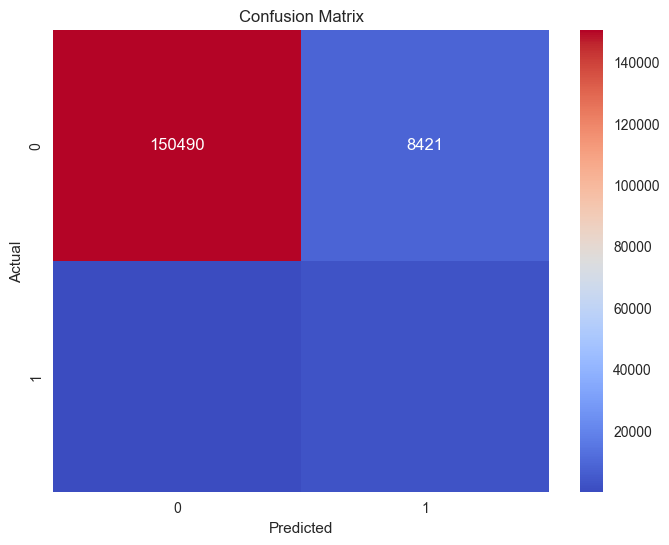

In [34]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
import plotly.figure_factory as ff

# Create confusion matrix as a plotly heatmap
fig = ff.create_annotated_heatmap(cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='Portland', showscale=True)
fig.update_layout(title_text='Confusion Matrix', width=500, height=500)  # Adjust size to make it square
fig.show()


In [33]:
print(cm)

[[150490   8421]
 [   143   2728]]


Shap Plot

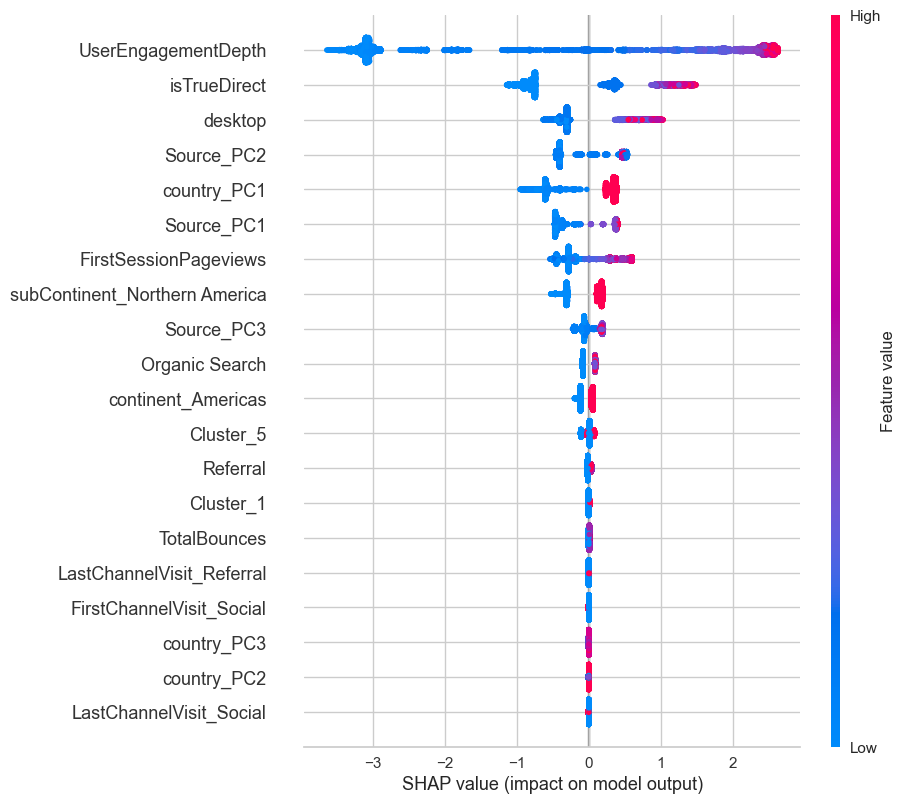

In [26]:
import shap

# Creating a SHAP explainer object for the model
explainer = shap.Explainer(model)
# Calculating SHAP values for the training set or validation set
shap_values = explainer(X_train)
# Plotting the beeswarm plot for class 1 SHAP values
shap.plots.beeswarm(shap_values, max_display=20)


# SHAP Value Analysis for Top Features

## Summary
The SHAP summary plot provides insights into the most influential features in the model. Below is an analysis of the top four features based on their impact:

### 1. UserEngagementDepth
- **Impact**: Primarily positive.
- **Interpretation**: Higher engagement depth consistently increases the likelihood of the target outcome, such as a conversion.

### 2. isTrueDirect
- **Impact**: Mostly positive, with tight clustering.
- **Interpretation**: Direct visits (as indicated by this feature) are generally predictive of a positive outcome, suggesting the importance of direct traffic in the model's decisions.

### 3. desktop
- **Impact**: Mixed, with a lean towards positive.
- **Interpretation**: Sessions from desktop devices show a generally positive influence on the model’s predictions, although some instances may slightly detract from the outcome.

### 4. Source_PC2
- **Impact**: Wide range, both positive and negative.
- **Interpretation**: This principal component of the 'source' feature shows a complex relationship with the target event, where both high and low values can either enhance or reduce the likelihood of the target event depending on specific circumstances.


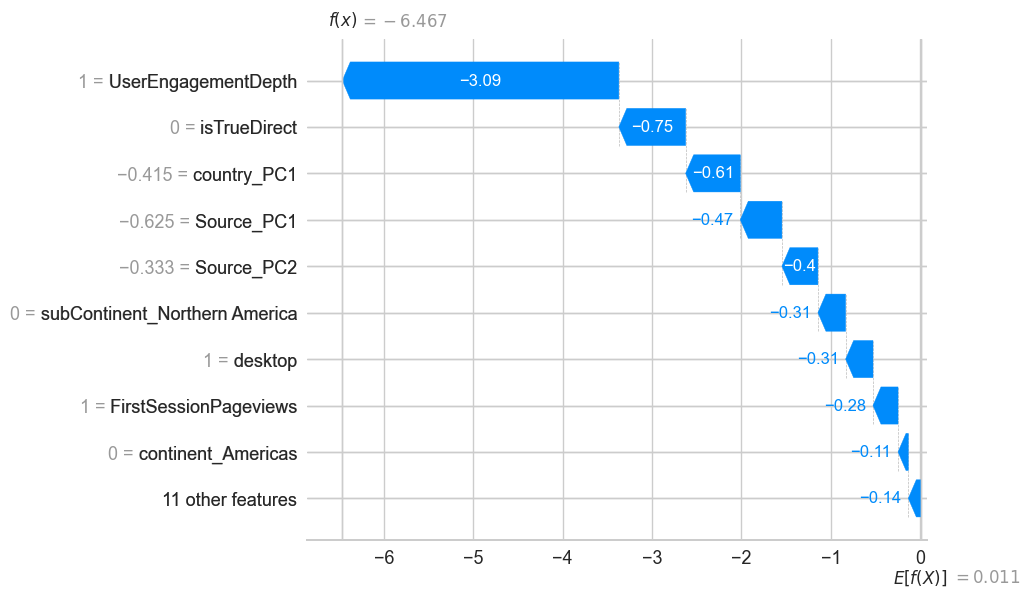

In [35]:
# Creating a SHAP explainer object for the model
explainer = shap.Explainer(model)

# Calculating SHAP values for a single prediction
# Assume you are interested in the first instance in your training set
single_instance = X_train.iloc[0:1]  # Use 0:1 to keep the DataFrame format
shap_values_single = explainer(single_instance)

# Plotting the SHAP values for the single prediction
shap.plots.waterfall(shap_values_single[0])

#beeswarm


In [30]:
X_train.shape

(12982, 20)

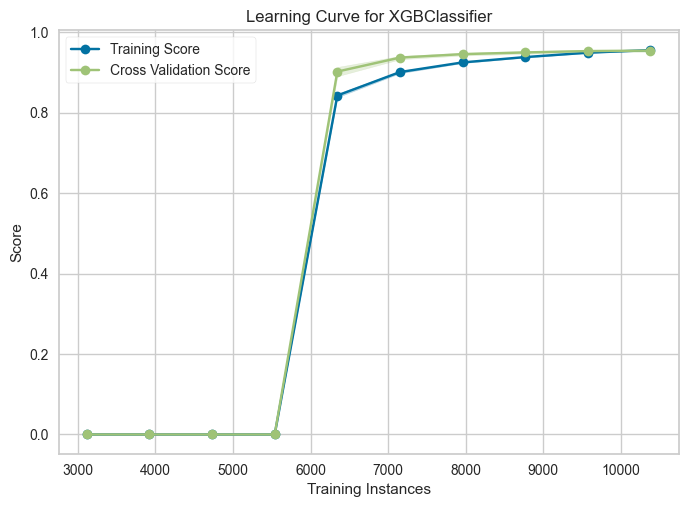

<Axes: title={'center': 'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [27]:
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)


visualizer = LearningCurve(
    model, 
    cv=cv, 
    scoring='f1', 
    train_sizes=sizes, 
    n_jobs=1
)

visualizer.fit(X_train, y_train)        
visualizer.poof()                       

Fetching an MLfIow Model from the Model Registry

Fetch a specific model version

In [19]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5000")  


In [20]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5000")  
model_name = "XGBoost"  # Replace with your model's name
model_version = "1"  # Replace with the desired version

model = mlflow.pyfunc.load_model(f"models:/{model_name}/{model_version}")


In [21]:
predict = model.predict(X_test[:5])
predict, y_test[:5]

(array([0, 0, 0, 0, 0]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: at_least_one_conversion, dtype: int64)

In [22]:
# print model information
model_info = model.metadata
print(model_info)


artifact_path: xgboost_model
flavors:
  python_function:
    data: model.xgb
    env:
      conda: conda.yaml
      virtualenv: python_env.yaml
    loader_module: mlflow.xgboost
    python_version: 3.10.13
  xgboost:
    code: null
    data: model.xgb
    model_class: xgboost.sklearn.XGBClassifier
    model_format: xgb
    xgb_version: 2.0.1
mlflow_version: 2.12.1
model_size_bytes: 516879
model_uuid: a28819fe9c0b41eab24ae7df2e4e2108
run_id: 195f88d9d00b46eba6c88330662a6281
utc_time_created: '2024-04-24 22:33:05.802060'



Deploy and get model wihtout registring


In [23]:
import mlflow
logged_model = 'runs:/b00eb7e626fa442f92cc8be48d3fbaf0/best_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(X_test[:5])

array([0, 0, 0, 0, 0])

Serve using Endpoint API
 
 Command Line run

 mlflow models serve -m "runs:/195f88d9d00b46eba6c88330662a6281/xgboost_model" -p 1234 --no-conda
 

In [24]:
import requests
import json

endpoint = "http://127.0.0.1:1234/invocations"

# Prepare the input data
input_data  = X_test.values.tolist()

inference_request = {
    "dataframe_records": input_data
}
response = requests.post(endpoint,json=inference_request)
print(response)

<Response [200]>


In [25]:
print(response.text)

{"predictions": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,